# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 13th of december at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 7 decembre 2020**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "bastien"
ln1 = "billiot"
fn2 = "simon"
ln2 = "demouchy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_billiot_bastien_and_demouchy_simon.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving optim_utils.py to optim_utils.py


In [ ]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [ ]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


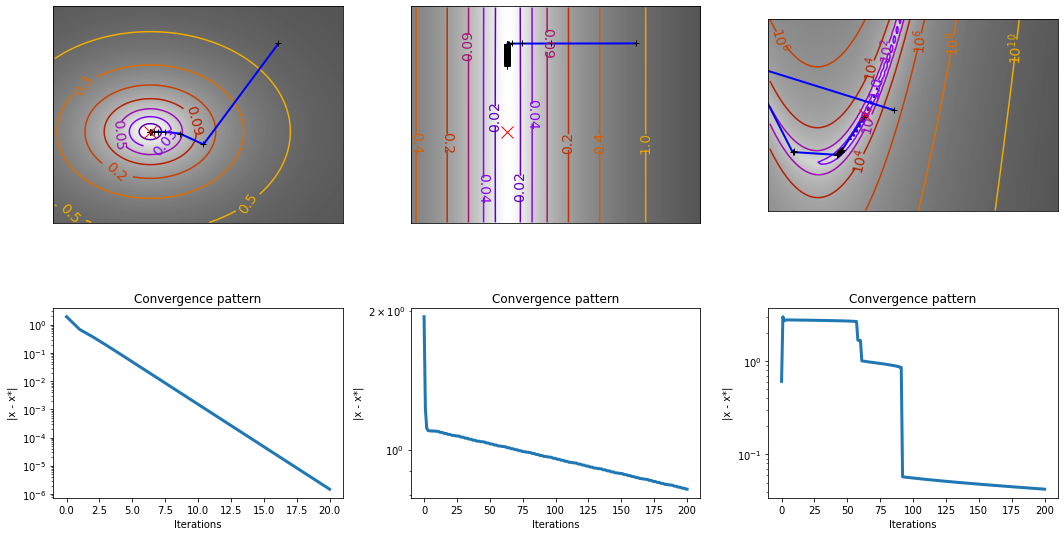

In [ ]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [ ]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO 
        H = f_hessian(x)
        eig = np.linalg.eigvals(H)
        if (eig >= lambda_threshold).all() == False :
          H += (lambda_threshold - min(eig))* np.identity(H.shape[0])
        d = -cg(H,grad_x)[0]

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


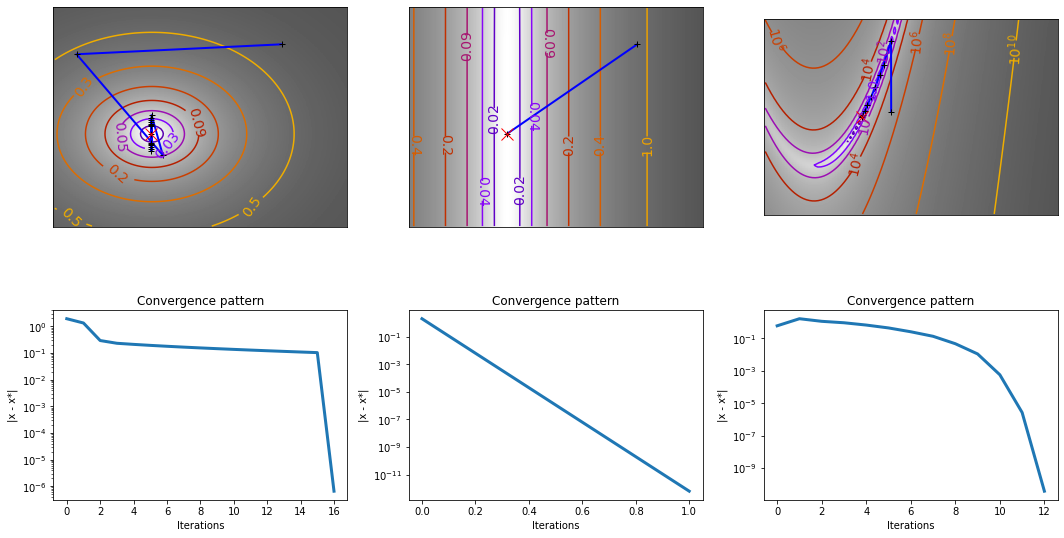

In [ ]:
test_solver(newton)

**COMMENTS**

The Newton solver converges in the three cases

1.   ***Case 1 :*** Although the kernel is not convex ($f(x) = -e^{-x^{2}}$), the Newton solver method manages to converge in 16 iterations with the hessian regularization and the optimal step size (using line search). This matches the theoretical results seen in course for non-convex problems. 
2.   ***Case 2 :*** The Newton solver converges in one step because the function, even though it is badly conditioned, is quadratic (and strongly convex). This matches the theoretical result seen in the course that on quadratic function, Newton method converges in one iteration independently of the chooice of $x_{0}$ (initial point) and that Newton method is not affected by the conditioning of the function. 
3.   ***Case 3 :*** The Rosenbrock function is non-quadratic, non-convex and badly cconditioned. However, we can see that the Newton solver manages to converge in 12 iterations while gradient descent was still stuck at an order of magnitude of$10^{-1}$ after 200 iterations. This also matches the theoretical results : the Newton method converges because it has quadratic convergence as opposed to the linear one of the gradient descent. 





# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [ ]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x

        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO

        first_term = np.outer(s,s) / np.dot(s, y)
        second_term = B.dot(np.outer(y,y).dot(B)) / (y.dot(B.dot(y)))
        B += first_term - second_term

        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


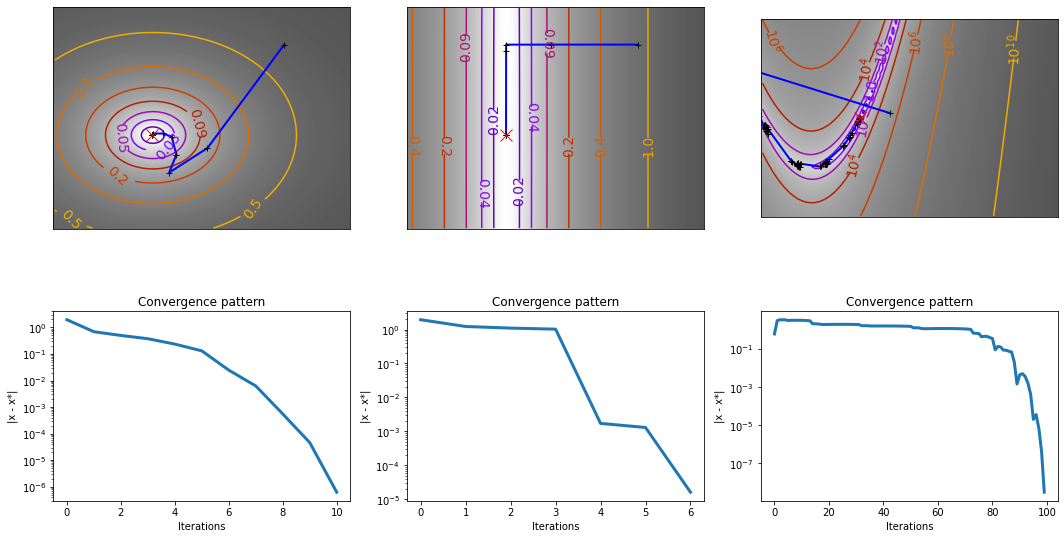

In [ ]:
test_solver(dfp)

**COMMENTS**

The Davidon Fletcher and Powell Algorithm converges in the 3 cases. 


1.   ***Case 1 :*** In this case, we can see that the DFP converges faster than the Newton solver. The rank 2 correction on the Hessian of DFP gave better results on this non-convex function. 
2.   ***Case 2 :*** According to the course theorem, as the function in this case is quadratic, the algorithm is like a conjugate gradient method, meaning it should converge in $n$ iterations (size of $x$). However, we can see that the algorithm needed 6 iterations when $n = 2$. Indeed, the theorem applies when the algorithm computes the optimal step size. In our computation, we use a line search to find the step size under Wolfe's condition which is an approximation and not an optimal step size. 
3.    ***Case 3 :*** The DFP algorithm is slower (100 iterations) than the Newton solver (12 iterations). This could be explained because the Newton method uses the exact Hessian matrix to find the optimal minimizing direction when the DFP algorithm uses an approximation of the inverse Hessian. 




# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [ ]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO 
        rho = 1/ np.dot(y,s)
        A = np.eye(len(x)) - rho * np.outer(y,s)
        B = np.dot(A.T,np.dot(B,A)) + rho * np.outer(s,s)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


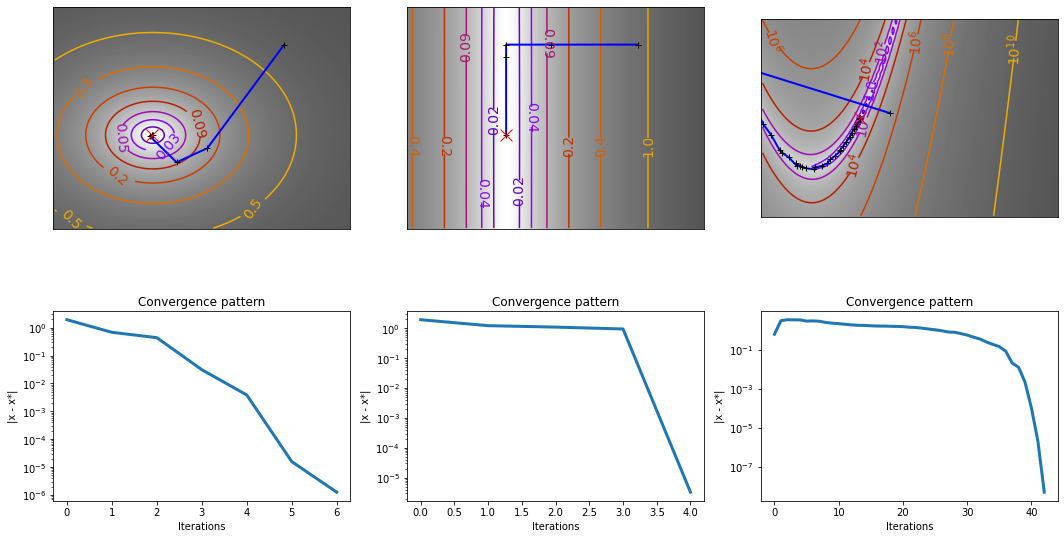

In [ ]:
test_solver(bfgs)

**COMMENTS**

BFGS algorithm converges in the three cases. We will mostly focus on comparing BFGS and DFP as their behaviour is similar (cf. course and curves).  


BFGS converges faster than DFP in all cases : 6 vs. 10 iterations for Case 1, 4 vs. 6 iterations for Case 2 and 40 vs 100 for Case 3. 


Indeed, whereas DFP requires the computation of the optimal step size, BFGS requires the optimal step size with line search. Therefore, as said in the course, BFGS is much less sensible than DFP to using an approximate step size and thus to using a line search combined with Wolfe's rule. In both of our implementations we computed a line search, therefore it works better with BFGS. Therefore, as we see for the quaddratic function, BFGS converges in 4 iterations (less than DFP). 



# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [ ]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    m = len(s_list)
    for i in reversed(range(m)):
      alpha = mu_list[i] * s_list[i].dot(q)
      q -= alpha * y_list[i]
      alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(m):
      beta = mu_list[i] * y_list[i].dot(r)
      r += (alpha_list[m-1-i] - beta) * s_list[i]
    return -r

In [ ]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


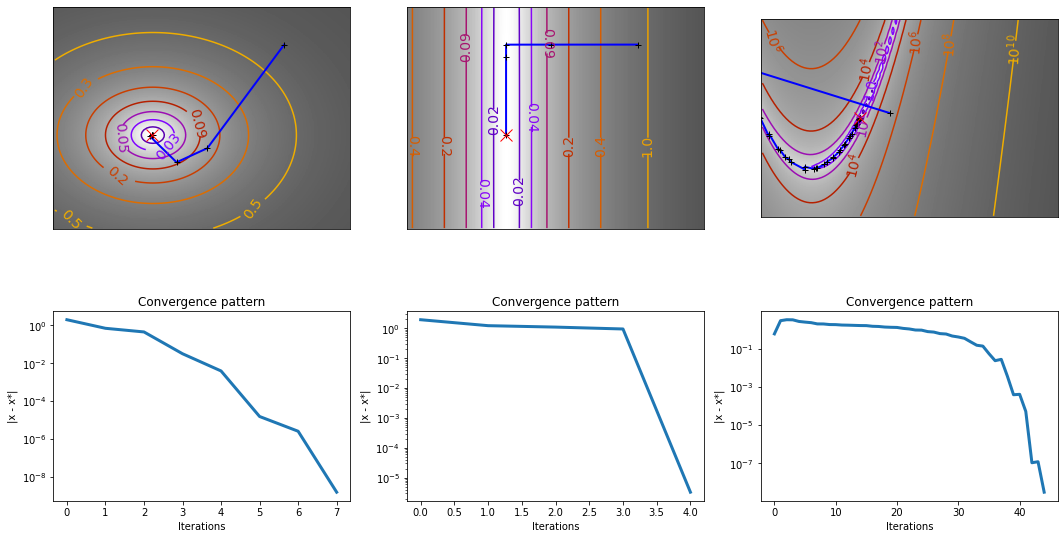

In [ ]:
test_solver(lbfgs)

***COMMENTS***

*   L-BFGS or Limited-memory BFGS is a variant of BFGS which limits memory usage.It only stores a few vectors to approximate the inverse of the Hessian instead of storing the whole Hessian.
*   This use of limiting the storage (size of Hessian $n \times n$) is helpful in applications where $n$ is very large such as computer vision or machine learning (where $n$ can be millions). However, in our case, $n=2$ so we don't have any memory storing problem. As a consequence, we can see that L-BFGS and BFGS are very similar. Number of iterations are close (a little bit more iterations in case 1 and 3 mainly explained as L-BFGS keeps less vectors used to approximate the Hessian instead of keeping the whole Hessian). 
*   We could work with higher $n$ to help shed light on the difference between both algorithms. 


 

